# Foam front propagation on primal mesh 2
The goal of this document is to re-implement the full primal solver for foam front
from scratch, starting with the generation of a mesh, and finishing with visualizations of the results.

## Generate mesh
To generate the mesh, first the meshpoints are generated, and then a Delaunay triangulation applied. The mesh then is represented in the openmesh format, by first generating the vertices at the determined points, and then generate the faces at triangles of the generated points. For the generation of faces, handles to the vertices are needed.

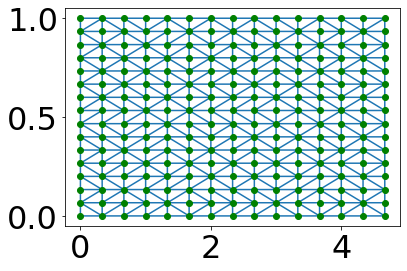

In [62]:
import openmesh as om
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

X = np.arange(0,5,5/15)
Y = np.arange(0,1.05,1/15)

P = np.array([[x,y] for y in Y for x in X])
T = Delaunay(P)

mesh = om.TriMesh()
vh=[]
for p in P:
    vh.append(mesh.add_vertex([p[0], p[1], 0]))    
for t in T.simplices:
    mesh.add_face(vh[t[0]],vh[t[1]],vh[t[2]])
    
plt.triplot(P[:,0],P[:,1],T.simplices)
plt.plot(P[:,0],P[:,1],'go')  
om.write_mesh('foam15.off', mesh)

## Generate the initial condition

In [15]:
V=mesh.points()
def get_T(x,y):
    return x*(1+0.5*(1-y)**2)

def get_S(x,y):
    return x*(1-y)

X=V[:,0]
Y=V[:,1]

T = get_T(V[:,0], V[:,1])
S = get_S(V[:,0], V[:,1])
U = np.array([*T, *S])


## Visualization


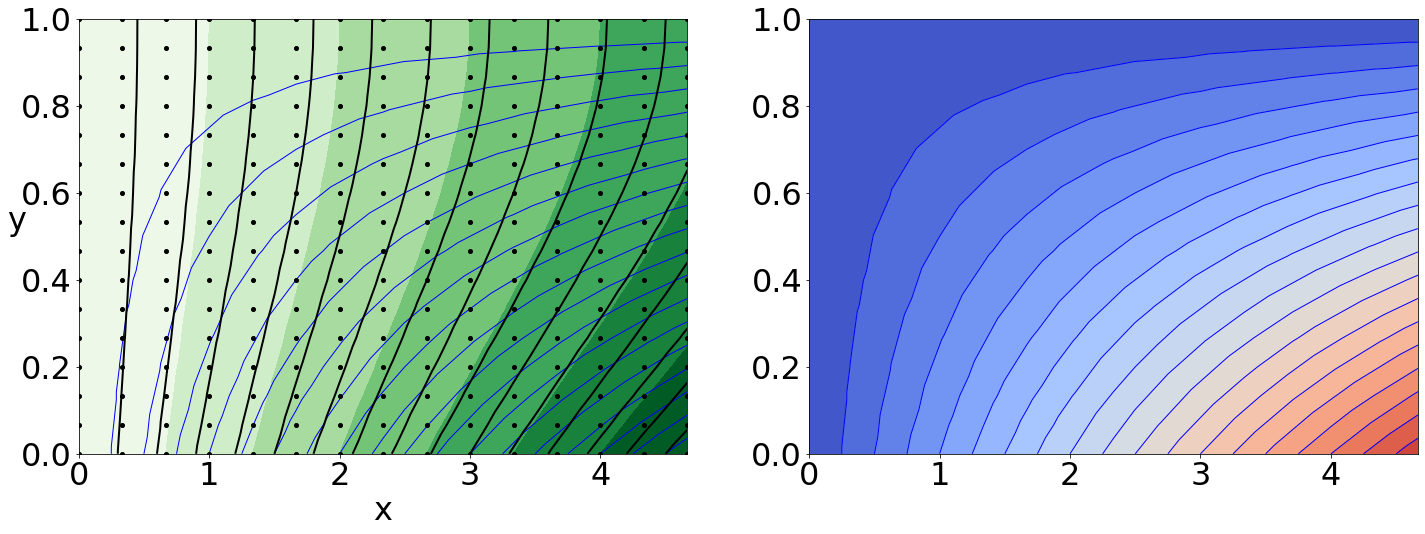

In [16]:
plt.rcParams.update({'font.size': 32})

cmap = plt.get_cmap('Greens')
cmap2=plt.cm.coolwarm
levels1 = np.linspace(0, 9, 21)
levels2 = np.linspace(0, 5, 21)

fig, (plt1, plt2) = plt.subplots(ncols=2, figsize=(24, 8))

plt1.plot(X, Y, '.k', markersize=8)
plt1.tricontourf(X, Y, T, cmap=cmap, zorder=1) # extent=[x0, y0, x1, y1],
plt1.tricontour(X, Y, T, colors='k', linewidths=2, levels=levels1)
plt1.tricontour(X, Y, S, colors='b' , zorder=1, linewidths=1, levels=levels2)

plt1.set_xlabel("x", fontsize=32)
h1=plt1.set_ylabel("y", fontsize=32)
h1.set_rotation(0)
plt.savefig('Tviz')

plt2.tricontourf(X, Y, S, cmap=cmap2 , zorder=1, levels=levels2)
plt2.tricontour(X, Y, S, colors='b' , zorder=1, linewidths=1, levels=levels2)

## getGradient

## Complementary subroutines

** Join into one [?] to identify bugs, but also to improve efficiency

* vlist, vhalf, nhalf, Shalf = getGeometry(vh,T)
* getWeights(alpha,Xlist):
* getChalf(vhalf, Thalf, gradient):

A lot of concepts are repeated. In terms of data processing, getGeometry is an add on to getGradient, which only enlarges the list of return arguments.

* getChalf uses output arguments of the other routines.
* maybe combine calculations of ahalf, bhalf with that of chalf 

* in the design adaption, if the angle conditions are not satisfied, then the corresponding non-triangle is not considered
* the calculation of the weights is effectively something different. As though the calculation of weights is not too extendend, there are serveral variants that deserve own considerations.

possible split of variables calculation
    * first set: vhalf, nhalf, Shalf, vlist,
    * second set: ahalf, bhalf, chalf, THETA, GRADIENT
    
* ahalf, bhalf even do not need to have an internal representation, as they can expressed compactly as normalized gradient, that is multiplied in a dot product by node positions.

"needed for"
ahalf, bhalf, chalf: SAPROX 
THETA, GRADIENT: "gav" / Hamiltonian of 
vhalf, Shalf: chalf
nhalf, vlist: p


getGrad: routine needed

In [50]:
import math

def getGrad2(I, U):
    m = np.zeros((2, 2))
    b = np.zeros((2, 1))

    for k in range(2):
        m[k,0] = V[I[k+1],0]-V[I[0],0]
        m[k,1] = V[I[k+1],1]-V[I[0],1]
        b[k] = U[k+1]-U[0]
                
    g = np.linalg.solve(m, b)    
    
    return g


def getHamiltonians(vh,U):
    nVertex = vh.idx()
    
    N = int(len(U)/2)
    T=U[0:N]
    S=U[N:]
    
    vlist = []
    nlist = []    
    vhalf = []
    nhalf = []
    Shalf = []    
    
    for vvh in mesh.vv(vh):
        idx = vvh.idx() # devuelve indice del VERTICE
        vlist.append(idx)
        nlist.append(V[nVertex,:]-V[idx,:])
        vhalf.append((V[nVertex,:]+V[idx,:])/2)
        Shalf.append((X[nVertex]+X[idx])/2)
        
    nlist = np.array(nlist)
    vhalf = np.array(vhalf)
    Shalf = np.array(Shalf)
    
    # print(nVertex,': \n', nlist,'\n')
    
    # for n in nlist:
    THETA=[]
    GRADIENT=[]
    SA = []
    SH = []
    
    for k in range(len(vlist)):
        v1 = nlist[k-1,:]
        v2 = nlist[k,:]        
        theta = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
        
        if (abs(theta) < math.pi-1e-3) and (abs(theta) > 1e-3) and (abs(theta-math.pi/2) > 1e-3):
            nhalf.append((v1+v2)/2)
            
            I = [nVertex, vlist[k-1], vlist[k]]                            
            g = getGrad2(I, T[I])
            THETA.append(theta)
            GRADIENT.append(g) # transpose? [.transpose()]
            
            gs = g/(np.linalg.norm(g)+1e-5)
            chalf = Shalf[k] - np.dot(gs.transpose(), vhalf[k,0:2])
            s0 = np.dot(gs.transpose(), V[nVertex,0:2]) + chalf
            # print('SA', SA, 's0', s0)
            # s0 = 1.0
            SA.append(s0)
            SH.append(Shalf[k]) # get a sublist for calculating weights [...]
        # else: just skip
    # end for
    
    # this allows to calculate the residual for $T_k$    
    THETA = np.array(THETA)  
    GRADIENT = np.array(GRADIENT)
    gav = GRADIENT.transpose().dot(THETA)/sum(THETA)
    rT = np.linalg.norm(gav) - V[nVertex,1]/(U[N+k] + 1e-5)
            
    # now continue to calculate the residual or $S_k$
    nhalf = np.array(nhalf)
    SA = np.array(SA)
    SH = np.array(SH)
    
    # now the calculation of the weights
    #
    # calculate weights
    # alpha = 0.5
    #
    # p = getWeightsT(SH)
    p = getWeightsNG(nhalf, GRADIENT)

    # p = p/np.linalg.norm(p)

    # print('s, p, SA', S[k], '; ', p, ';', SA)
    # print(len(SA), '; ', len(SH), '; ', len(p), ', ', len(GRADIENT),'; ', len(chalf))
    #
    # rT = S[k] - np.dot(p,SA)
    rS = S[k] - np.dot(p.transpose(), SA)
    
    # normalize gradients, corrsponding to $\nabla S$
    # return ahalf, bhalf, chalf, THETA, GRADIENT, vhalf, nhalf, Shalf, vlist
    # return SA, THETA, GRADIENT, nhalf,  vlist
    return rT, rS

alpha = 0.5 # global variable [!; if not modified in the special subroutine]

# calculate weights
def getWeightsT(SH):
# might run over any list
    Ssort = np.sort(SH)
    # print('increasing??', Ssort) # [increasing !]
    
    Salpha = (1-alpha)*Ssort[-1] + alpha*Ssort[1]
    # Salpha = Ssort[2]
    
    Splus = np.maximum(Salpha - SH, 0)
 
    if sum(Splus) < 1e-5:
        Splus = Splus + 1
        print('nan [weights] !!!')        
        
    p = Splus/sum(Splus+1e-5)
    # print('\n', SH, '\n \n ', p)
    return p


def getWeightsNG(nhalf,gradient):    
    # print(nhalf[:, 0:2], '\n \n', gradient, '\n')        
    NG=[]
    for k in range(len(gradient)):
        # print(gradient[k],'<->', nhalf[k, 0:2])    
        # ng = np.dot(nhalf[k,0:2].transpose(), gradient[k].transpose())
        ng = np.dot(nhalf[k,0:2].transpose(), gradient[k])
        NG.append(ng)
                
    NG=np.array(NG)
    p = np.ones(np.shape(nhalf))    
    # p = p/np.linalg.norm(p)
    print('------\n', NG)
    
#    Sng = np.sort(-NG)
    # Sng = NG.sort()
    Sng= np.array(sorted(NG))
    print('Sng', Sng)
        
    # print('------\n', Sng[-2])

    alpha=1 # reforcing the unique value

    
    Salpha = (1-alpha)*Sng[0] + alpha*Sng[-2]
    Splus = np.maximum(Sng - Salpha, 0)
 
    if sum(Splus) < 1e-5:
        Splus = Splus + 1
        print('nan [weights] !!!')  
    
    p = Splus/sum(Splus)
    # print('\n\n p:', p)
    # print(k,'-> p: \n', p)  
        
    return p    




In [64]:
for vh in mesh.vertices():
    k = vh.idx()
    if k > 40:
        break

print(k)

        
rT, rS = getHamiltonians(vh,U) 





41


IndexError: index 41 is out of bounds for axis 0 with size 15

## Calculation of the residual
The calculation of the residual is the major subroutine. The the subroutine that calculates the cost function is a sort of "corrolary", that allows for the usage of optimization routines that calculate a minimum (of the cost function) instead of solving a system of equations (for the residual).

### Something happens
* What is the best choice for the weights?
* What is the handling for different sizes of the list?
* Why is the list empty?


In [53]:
ymax=np.max(V[k,1])
# ymax=1
nVertex=[]

def residual(U):
    N = int(len(U)/2)
    T=U[0:N]
    S=U[N:]    
    r = np.zeros(np.shape(U))
    for vh in mesh.vertices():
        k = vh.idx()            
        if V[k,0] == 0: # x==0
            r[k]=U[k]     # T(x=0,y) = 0
            r[k+N]=U[k+N] # S(x=0,y) = 0
        elif V[k,1] == 1: # y==0
            r[k]=U[k]-V[k,0] # T(x,y=1) = x
            r[k+N]=U[k+N]    # T(x,y=1) = 0
        else: # interior
            # print(k)
            
            rT, rS = getHamiltonians(vh,U)
            
            r[nVertex] = rS
            r[k+N] = rT
            
        #
        #
        # print('k =', k, ', \t r :', r)
        # 
        print(k)
        
    return r

def cost(u):
    R=residual(u)
    c=np.inner(R,R)
    return c

print('---- > --------------------------------------')
res = residual(U)
print(res)
print('------ < ------------------------------------')
print(len(res), len(U))

---- > --------------------------------------
0
------
 [[ 0.5       ]
 [ 0.26074074]
 [-0.21777778]
 [-0.47851852]]
Sng [[-0.47851852]
 [-0.21777778]
 [ 0.26074074]
 [ 0.5       ]]
1
------
 [[-0.1962963 ]
 [-0.46777778]]
Sng [[-0.46777778]
 [-0.1962963 ]]
2
------
 [[-0.17481481]
 [-0.45703704]]
Sng [[-0.45703704]
 [-0.17481481]]
3
------
 []
Sng []


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in double_scalars


IndexError: index 0 is out of bounds for axis 0 with size 0

## Solve the equations directly
For each vertex, T gives one equation, S gives two equations, in total three equations for two variables

# 
Calculate gradient for any variable
* Should be there one routine for the two variables?
* Should the Hamiltonian already ve calculated?

In [57]:
def getGradient(vh, W):
    nVertex = vh.idx()
    
    vlist = []
    nlist = []    
    
    for vvh in mesh.vv(vh):
        idx = vvh.idx() # devuelve indice del VERTICE
        vlist.append(idx)
        nlist.append(V[nVertex,:]-V[idx,:])
    nlist=np.array(nlist)
    # print(nVertex,': \n', nlist,'\n')
    
    # for n in nlist:
    THETA=[]
    GRADIENT=[]
    for k in range(len(vlist)):
            v1 = nlist[k-1,:]
            v2 = nlist[k,:]
            theta = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
            I=[nVertex, vlist[k-1], vlist[k]]                
                
            if (abs(theta)<math.pi-1e-3) and (abs(theta) > 1e-3) and (abs(theta-math.pi/2)>1e-3):
                g = getGrad2(I, W[I])
                THETA.append(theta)
                GRADIENT.append(g)
                
    THETA=np.array(THETA)  
    GRADIENT=np.array(GRADIENT)

    return THETA, GRADIENT

print('nVertex:', vh.idx())
theta, gradient = getGradient(vh, T)

print('\n sum(', theta,') = % .2f' % sum(theta),'\n \n')
print('GRADIENT: \n', gradient.transpose(),'\n \n')

nVertex: 41

 sum( [1.37340077 0.19739556 0.19739556 1.37340077 1.37340077 0.19739556] ) =  4.71 
 

GRADIENT: 
 [[[ 1.32        1.37555556  1.37555556  1.43555556  1.43555556
    1.37555556]
  [-3.05555556 -3.33333333 -3.6        -3.3        -3.3
   -3.        ]]] 
 



## Solving the system of equations
The solution of the system of equations is the main test on whether the residual is implemented adecuately. 

In [ ]:
from scipy import optimize
from scipy.optimize import fsolve, newton_krylov

# res = optimize.broyden1(residual, U)
# res =  fsolve(residual, U)
# res = newton_krylov(residual, U, method='lgmres', verbose=1)
res = newton_krylov(residual, U, method='lgmres', verbose=1)

# print('Residual: %g' % abs(residual(res)).max())